# Scoring functions for reward distribution
## Saturn Aliens

### Maria Silva, August 2022

In [1]:
import numpy as np
import pandas as pd
import scipy.special as sps  
import matplotlib.pyplot as plt

## Bandwidth function

Given:

- $n$ node operators ($i=1, 2, ..., n$)
- $R$: amount of rewards to distribute in current epoch
- $b_i$: total bandwidth served by node operator $i$ in the current epoch

The rewards paid to node operator $i$ in the current epoch are defined by the following **scoring function**:

$S(b_i) := \frac{b_i^k}{\sum_{j=1}^n b_j^k} \cdot R$

where $k \in \mathbb{R}^+$ is any real positive value.

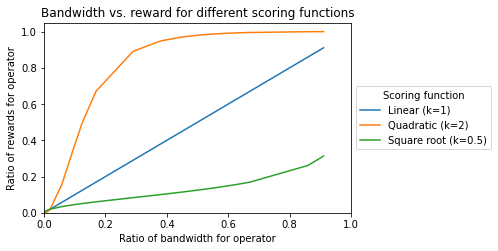

In [2]:
B_vec = np.ones(49).astype(float)
bi_vec = np.array([0.01, 0.1, 0.5, 1, 3, 5,7, 10, 20, 30, 40, 50, 60,70, 80,90, 100, 300, 500]).astype(float)

bi_ratio_vec = bi_vec / (sum(B_vec) + bi_vec)

# Linear function
linear_B_vec = sum(B_vec) + bi_vec
linear_ri_ratio_vec = bi_vec / linear_B_vec

# Squared function
square_B_vec = sum(B_vec**2) + bi_vec**2
square_ri_ratio_vec = (bi_vec**2 / square_B_vec)

# Square root function
root_B_vec = sum(B_vec**0.5) + bi_vec**0.5
root_ri_ratio_vec = (bi_vec**0.5 / root_B_vec)

plt.figure(figsize=(5.5,3.5))
plt.plot(bi_ratio_vec, linear_ri_ratio_vec, label="Linear (k=1)")
plt.plot(bi_ratio_vec, square_ri_ratio_vec, label="Quadratic (k=2)")
plt.plot(bi_ratio_vec, root_ri_ratio_vec, label="Square root (k=0.5)")
plt.xlim(0,1)
plt.ylim(0,1.05)
plt.title("Bandwidth vs. reward for different scoring functions")
plt.xlabel("Ratio of bandwidth for operator")
plt.ylabel("Ratio of rewards for operator")
plt.legend(title="Scoring function", loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Time-to-first-byte (TTFB) functions

Let's assume that TTFB follows a Gama distribution:

mean:  0.992337858878984
median:  0.7976753861732864
std:  0.7251270967648997


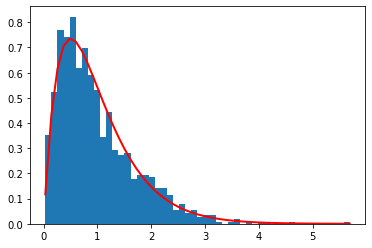

In [43]:
shape, scale = 2., 0.5
s = np.random.gamma(shape, scale, 1000)
print("mean: ", np.mean(s))
print("median: ", np.median(s))
print("std: ", np.std(s))

count, bins, ignored = plt.hist(s, 50, density=True)
y = bins**(shape-1)*(np.exp(-bins/scale)/(sps.gamma(shape)*scale**shape))
plt.plot(bins, y, linewidth=2, color='r')  
plt.show()

What if we use the z-score to build the scoring function? There are some problems with this:

1. z-score is not bounded
2. Outliers impact the network's average

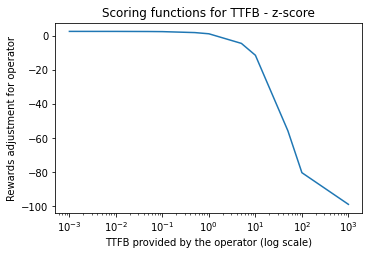

In [44]:
ttfb_vec = np.random.gamma(2., 0.5, 10000)
ttfb_i_vec = np.array([0.001, 0.01, 0.05, 0.1, 0.5, 1,5, 10, 50, 100, 1000]).astype(float)

avg_ttfb_vec = (sum(ttfb_vec) + ttfb_i_vec)/(len(ttfb_vec)+1)
std_ttfb_vec = [
    np.sqrt((sum((ttfb_vec-avg_ttfb_vec[i])**2) + (ttfb_i_vec[i] - avg_ttfb_vec[i])**2)/(len(ttfb_vec)+1)) 
    for i in range(len(ttfb_i_vec))
]

z_score_vec = (ttfb_i_vec-avg_ttfb_vec)/std_ttfb_vec

plt.figure(figsize=(5.5,3.5))
plt.plot(ttfb_i_vec, 1-z_score_vec)
plt.xscale('log')
plt.title("Scoring functions for TTFB - z-score")
plt.xlabel("TTFB provided by the operator (log scale)")
plt.ylabel("Rewards adjustment for operator")
plt.show()

What if we use a function based on the median instead of the average? The median is not impacted by outliers.

However, using the median still leads to an unbounded score.

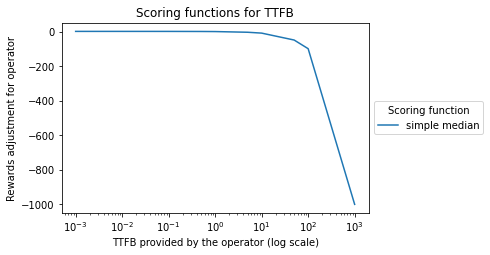

In [42]:
ttfb_vec = np.random.gamma(2., 0.5, 1000)
ttfb_i_vec = np.array([0.001, 0.01, 0.05, 0.1, 0.5, 1,5, 10, 50, 100, 1000]).astype(float)
ttfb_vec_list = [np.concatenate([ttfb_vec, [ttfb_i]]) for ttfb_i in ttfb_i_vec]

med_ttfb_vec = np.array([np.median(ttfb_vec) for ttfb_vec in ttfb_vec_list])

z_score_vec = (ttfb_i_vec-avg_ttfb_vec)/std_ttfb_vec

plt.figure(figsize=(5.5,3.5))
plt.plot(ttfb_i_vec, med_ttfb_vec-ttfb_i_vec, label="simple median")
plt.xscale('log')
plt.title("Scoring functions for TTFB")
plt.xlabel("TTFB provided by the operator (log scale)")
plt.ylabel("Rewards adjustment for operator")
plt.legend(title="Scoring function", loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

**Solution:** Use the number of requests with a TTFB lower than a given threshold. With this metric, we can apply the same formulas as we used for bandwidth directly.